# Load

In [1]:
!pip install opencv-python-headless scikit-fuzzy torch torchvision segment-anything

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skfuzzy.cluster import cmeans
import torch
import torchvision.models as models
import torchvision.transforms as T
from segment_anything import SamPredictor, sam_model_registry

image_paths = ["/content/image 1.jpg", "/content/image 3.bmp", "/content/image 2.jpg"]

def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not load image: {path}")
    return img

def plot_all(img, masks, titles):
    n = len(masks) + 1
    plt.figure(figsize=(4 * n, 4))
    plt.subplot(1, n, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    for i, (mask, title) in enumerate(zip(masks, titles)):
        plt.subplot(1, n, i + 2)
        plt.imshow(img, cmap='gray')
        plt.imshow(mask, cmap='jet', alpha=0.4)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# K-Means

In [3]:
def segment_kmeans(img, K=2):
    Z = img.reshape((-1,1)).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented = centers[labels.flatten()].reshape(img.shape)
    return segmented

# Fuzzy C-Means

In [4]:
def segment_fcm(img, K=2):
    data = img.reshape(1, -1).astype(np.float64)
    cntr, u, _, _, _, _, _ = cmeans(data, c=K, m=2, error=1e-5, maxiter=100)
    cluster = np.argmax(u, axis=0)
    return cluster.reshape(img.shape)

# ResNet

In [5]:
# 5. ResNet Feature Extraction
resnet = models.resnet18(pretrained=True).eval()
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-2])

def get_resnet_features(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    x = T.ToTensor()(img_rgb).unsqueeze(0)
    with torch.no_grad():
        feats = feature_extractor(x)
    feats = torch.nn.functional.interpolate(feats, size=img.shape, mode='bilinear', align_corners=False)
    feats = feats.squeeze(0).permute(1,2,0).cpu().numpy()
    return feats

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


## K-Means

In [6]:
def segment_resnet_kmeans(img, K=2):
    feats = get_resnet_features(img)
    combined = np.concatenate([img[:,:,None], feats], axis=2)
    Z = combined.reshape(-1, combined.shape[2]).astype(np.float32)
    _, labels, _ = cv2.kmeans(Z, K, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2),
                              10, cv2.KMEANS_RANDOM_CENTERS)
    return labels.reshape(img.shape)

## Fuzzy C-Means

In [7]:
def segment_resnet_fcm(img, K=2):
    feats = get_resnet_features(img)
    combined = np.concatenate([img[:,:,None], feats], axis=2)
    data = combined.reshape(-1, combined.shape[2]).T
    cntr, u, _, _, _, _, _ = cmeans(data, c=K, m=2, error=1e-5, maxiter=100)
    labels = np.argmax(u, axis=0)
    return labels.reshape(img.shape)

# SAM

In [10]:
# 2. Download SAM checkpoint
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [11]:
sam = sam_model_registry["default"](checkpoint="sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)

def segment_sam(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    predictor.set_image(img_rgb)
    h, w = img.shape
    box = np.array([0, 0, w, h])
    masks, _, _ = predictor.predict(box=box, multimask_output=False)
    return masks[0].astype(np.uint8)

# Sample Outputs

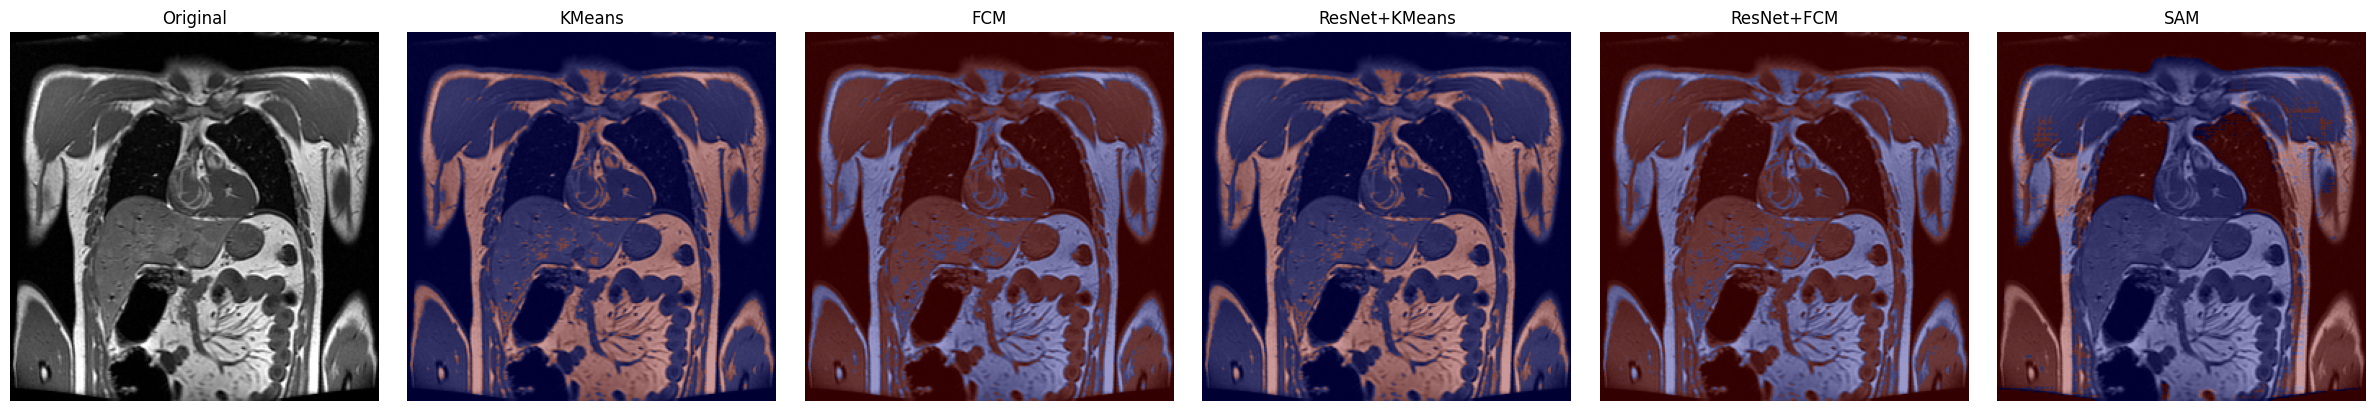





## 🧠 Takeaways
- **Best overall (among clustering)**: ResNet + FCM
- **Best detailed masks**: SAM (especially with prompts)
- **Quick & dirty baseline**: K-Means

----
### 🔹 K-Means
- **What it does**: Clusters based only on pixel intensity.
- **Pros**: Super fast, simple, and works okay for basic regions.
- **Cons**: No idea of structure or context — boundaries are messy.

---

### 🔹 Fuzzy C-Means (FCM)
- **What it does**: Like K-Means, but softer — pixels can belong to multiple clusters.
- **Pros**: Smoother segmentation, handles intensity variation better.
- **Cons**: Still lacks awareness of organ shapes or textures.

---

### 🔹 ResNet + K-Means
- **What it does**: Uses deep features from ResNet before clustering.
- **Pros**: Picks up on shapes and textures — clearer organ boundaries.
- **Cons**: Slower and still not perfect for subtle regions.

---

### 🔹 ResNet + FCM
- **What it does**: Combines smooth clustering with ResNet’s deeper features.
- **Pros**: Cleanest and most coherent among clustering methods.
- **Cons**: Heavier and slower to run.

---

### 🔹 Segment Anything (SAM)
- **What it does**: Zero-shot segmentation using a foundation model.
- **Pros**: Great at outlining organs, especially with visible edges.
- **Cons**: May oversegment or miss things in low-contrast areas.

---

## 🔍 Summary Table

| Method              | Accuracy | Noise Handling | Smart Segmentation | Speed   |
|---------------------|----------|----------------|---------------------|---------|
| **K-Means**         | Low      | Low            | None                | ⚡ Fast |
| **FCM**             | Medium   | Medium         | None                | 🚶‍♂️ Mid |
| **ResNet + K-Means**| Good     | Medium         | Some                | 🐢 Slow |
| **ResNet + FCM**    | Great    | High           | Decent              | 🐢 Slow |
| **SAM**             | Great    | Medium         | High                | 🏃‍♂️ Fast |


Processing: /content/image 1.jpg
 - KMeans
 - FCM
 - ResNet+KMeans
 - ResNet+FCM
 - SAM


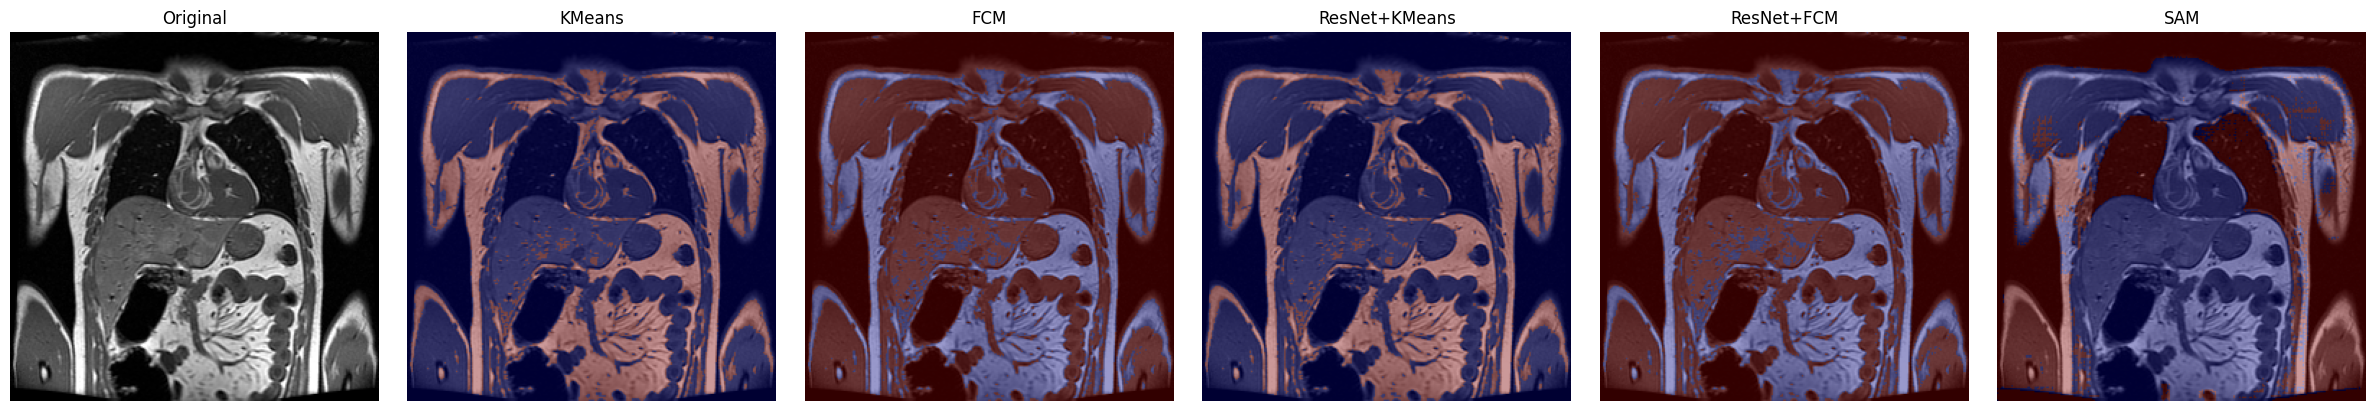

Processing: /content/image 3.bmp
 - KMeans
 - FCM
 - ResNet+KMeans
 - ResNet+FCM
 - SAM


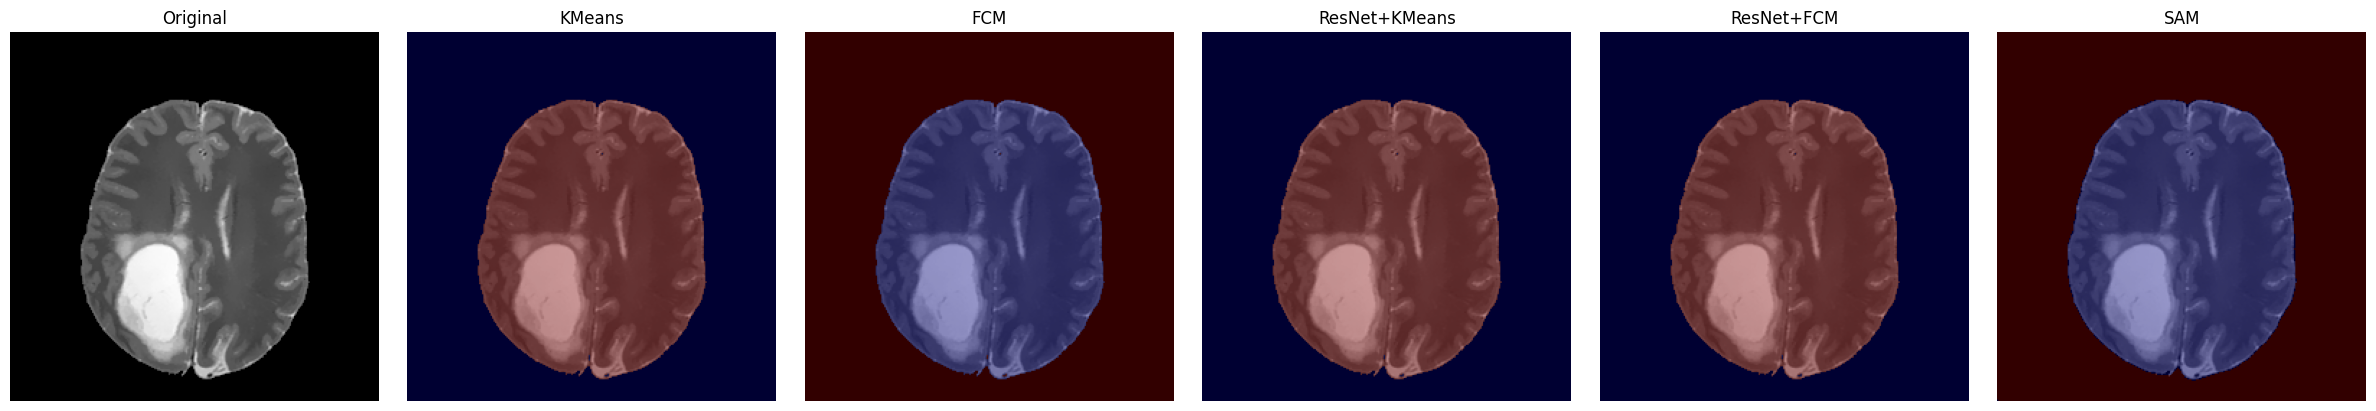

Processing: /content/image 2.jpg
 - KMeans
 - FCM
 - ResNet+KMeans
 - ResNet+FCM
 - SAM


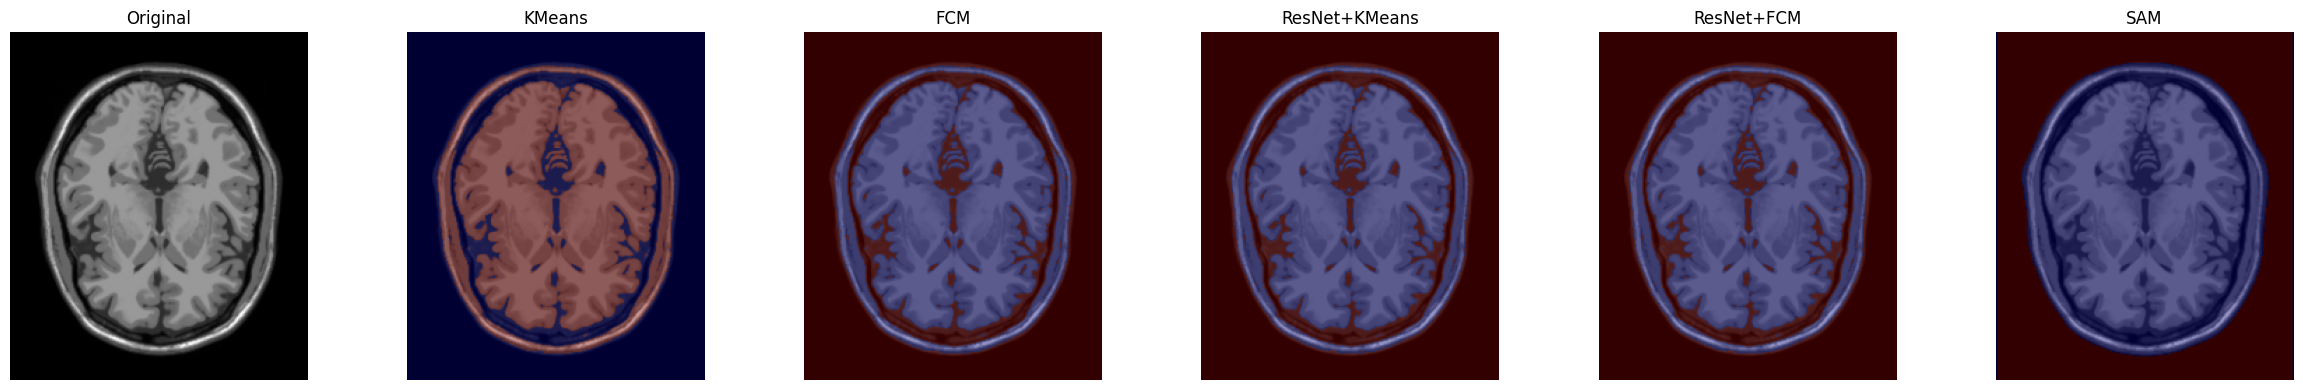

In [12]:
methods = [
    ("KMeans", segment_kmeans),
    ("FCM", segment_fcm),
    ("ResNet+KMeans", segment_resnet_kmeans),
    ("ResNet+FCM", segment_resnet_fcm),
    ("SAM", segment_sam)
]

for path in image_paths:
    print(f"Processing: {path}")
    img = load_image(path)
    masks, titles = [], []
    for name, fn in methods:
        print(f" - {name}")
        result = fn(img)
        masks.append(result)
        titles.append(name)
    plot_all(img, masks, titles)